In [6]:
using Plots, SparseArrays, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")

In [7]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f = pointsource_half2D(2*n)
σ = float(-10)
sigmas = spdiagm(σ*ones(length(grid)^2))
H = helmholtz2D(grid,sigmas);
sol = H \ f;

In [8]:
u = zeros(length(f))
errors = Float64[]

for _ in 1:20
    u = nonUniformVcycle2D(
        grid=grid,
        A=H,
        f=f,
        u=u,
        nu1=3,
        nu2=3,
        recursion_depth=50)
    error = norm(sol - u)
    push!(errors, error)
end


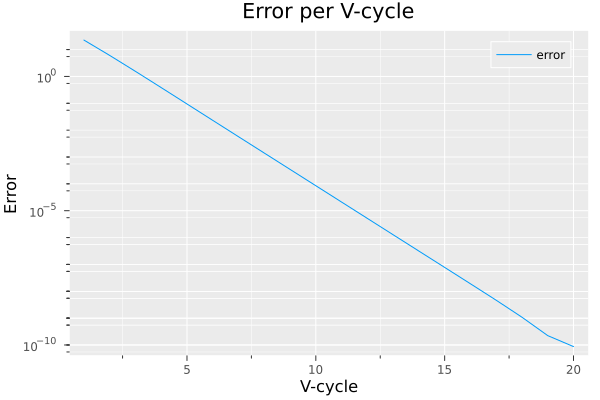

In [9]:
theme(:ggplot2)
plot(errors, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

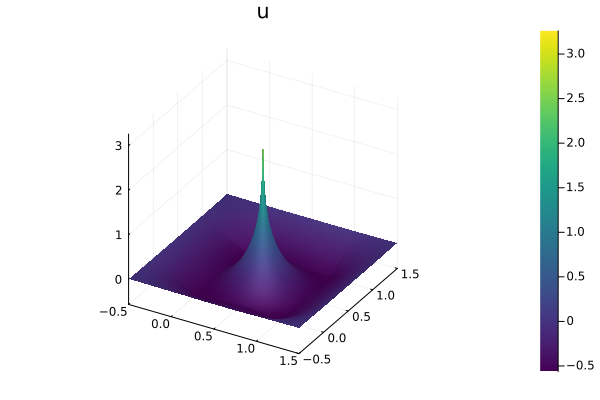

In [10]:
theme(:default)
x = y = range(-0.5, stop=1.5, length=2n-1)
z = reshape(real(u), 2n-1, 2n-1)
surface(x, y, z, color=:viridis, title="u")